In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

!pip install git+git@github.com/VisiumCH/AMLD-2021-Graphs.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from time import time

from ipywidgets import interact, interact_manual, FloatSlider
import pandas as pd
import numpy as np
import torch

# Shedding light on obscure graph deep learning

Deep learning techniques on graphs have achieved impressive results in recent years. Graph neural networks (GNN) combine node feature information with the graph structure in order to make their predictions. However, this strategy results in complex models, whose predictions can be hard to interpret.

In this workshop, you will get familiar with graph data and you will learn the fundamental concepts behind graph neural networks. After building and training your own GNN, you'll be introduced to GNNExplainer, a model-agnostic framework for interpreting GNN results. Thus, you will be able to visualize explanations for your GNN's predictions, giving a sense to the model outputs.

---

# I. Working with graphs in PyTorch Geometric

Graphs are a powerful means to represent many real word data that contain inherent structure. A graph is a pair $G=(V, E)$, where $V$ is a set of elements called vertices (or nodes) and $E$ is a set of edges (links), where an edge is an ordered pair of vertices. This way, edges represent relations among nodes.

We will be working with [PyTorch Geometric][1], a useful extension of PyTorch designed to work with graphs. A single graph in PyTorch Geometric is described by an instance of `torch_geometric.data.Data`, which can hold several attributes, among which:

* `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

* `data.edge_index`: Graph connectivity tensor with shape `[2, num_edges]` and type `torch.long`. Note that one would expect the **node pairs** to be saved as rows, but in this format they are **saved as columns** of the `edge_index` matrix.

* `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

* `data.y`: Target to train against, e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

Not all of these fields must be present and the user can define his own attributes. The following cell shows an example for the creation of a simple graph in PyTorch Geometric.

[1]: https://pytorch-geometric.readthedocs.io/en/latest/


In [ ]:
import torch
from torch_geometric.data import Data
## Create an undirected graph having three nodes (0, 1, 2).
## Nodes 0 and 1 are connected; nodes 1 and 2 are connected (in both directions).
## Each node has a single feature. These features are equal to
## -1, 0, 1 for the three nodes respectively, in this order.
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G1 = Data(x=x, edge_index=edge_index)

## Exercise 1
In order to familiarize yourself with PyTorch Geometric, complete the implementation of the following function, which takes a graph as input (i.e. a `torch_geometric.data.Data` object), and returns `True` if the graph is **un**directed, `False` if it is directed. We say that a graph is undirected if for each existing edge $(i, j)$ there exists also the edge in the opposite direction, $(j,i)$. For simplicity, you may assume that the graph is connected (there are no isolated nodes) and there are no self loops.

In [ ]:
def is_undirected(graph):
  ## TODO: implement me!
  pass

Now verify the correctness of the function you wrote by comparing the results with the available PyTorch Geometric `is_directed()` method.

In [ ]:
print("Your function works correctly on G1: ", G1.is_undirected() == is_undirected(G1))

# Let us check the result on a second graph
edge_index = torch.tensor([[0, 1, 1],
                           [1, 0, 2]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G2 = Data(x=x, edge_index=edge_index)

print("Your function works correctly on G2: ", G2.is_undirected() == is_undirected(G2))

## Dataloading
Pytorch Geometric can be used to easily load and process several benchmark graph datasets. These include the Mutagenicity dataset, which we are going to use in this workshop.

### Mutagenicity: a Molecule Classification Dataset
The [Mutagenicity dataset][1] is one of the datasets from the [TUDataset][2] collection. Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 14-dimensional and represent the one-hot-encoding for each atom, which can be one of 14 different elements. For each graph we are given a binary label which indicates whether a molecule has a [mutagenic effect][3] on the Gram-negative bacterium S. typhimurium. Thus, the learning task we will later focus on for this dataset will be **graph-level classification**.


[1]: https://pubs.acs.org/doi/abs/10.1021/jm040835a
[2]: https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
[3]: https://pubs.acs.org/doi/10.1021/jm00106a046

#### Transforms

When loading a dataset, PyTorch Geometric lets the user pass some **transforms** to apply to the data. Here, we define the class `AddSymbols`, which sets the `symbols` attribute of each graph to be equal to a list containing the string representation of each atom in the molecule, which is retrieved from the features one-hot-encoding. This will be later useful for molecule visualization.

In [ ]:
# Atom types, ordered accroding to one-hot-encoding
MUT_LABEL_ENC = pd.Series(data = ["C","O", "Cl","H","N","F","Br","S","P","I","Na","K","Li","Ca"])
print("Number of different elements: ", len(MUT_LABEL_ENC))

# Define transform
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph

In [ ]:
from torch_geometric.datasets import TUDataset

# Load the dataset
dataset = TUDataset(
    root=".", name="Mutagenicity",
    transform=AddSymbols(),
).shuffle()

In the previous exercise we have seen that PyTorch Geometric implements the convenient attribute `is_directed()`. Together with that, there are other useful dataset and graph attributes.

Let us use them to visualize some properties of the Mutagenetic dataset...

In [ ]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Samples per class: {[ np.sum([1 for graph in dataset if graph.y == i ]) for i in range(dataset.num_classes) ]}')

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)
print(f"{len(np.unique(all_atoms))} unique atoms: {np.unique(all_atoms)}")


...and some properties of the first graph in the dataset.

In [ ]:
G = dataset[0]  # Get the first graph object.
print(G)
# Gather some statistics about the first graph.
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')

## Visualization

To represent the molecules we will use `networkx`, a graph visualization library. The molecule visualization function `plot_mol` is written in the `visualization.py` script. It first converts a `torch_geometric.data.Data` object to a networkx object by calling the pyTorch Geometric `to_networkx` function, and it then calls the `networkx.draw_networkx` method.

## Exercise 2
Before using the `plot_mol` function, try to visualize the graph by yourself by writing a few lines in the following cell. As suggested, use the [`to_networkx`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html) and the [`draw_networkx`](https://networkx.org/documentation/stable//reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx) methods. For molecule visualization, we suggest to use the networkx [`kamada_kawai_layout`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html).


In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx  # Conversion function

In [ ]:
G = dataset[2]
## TO DO: draw G!

Let us now visualize the molecules using the `plot_mol` function that we already implemented.

The `interact` widget allows for easy visualization of the different molecules in the dataset: try it out!

In [ ]:
from src import plot_mol

In [ ]:
interact(
    lambda graph: plot_mol(
        dataset[graph],
        edge_type=dataset[graph].edge_attr[:,0].numpy(),
    ),
    graph=range(len(dataset))
)

## Batching in Pytorch Geometric
Neural networks typically work on batches of input data. For efficiency reasons, a Pytorch Geometric Dataloader builds a batch of graphs by considering it as a unique big graph: the big graph adjacency matrix is built by stacking diagonally the adjacency matrices of the graphs in the batch (which are defined by `edge_index`); features and target matrices are concatenated in the node dimension. This composition allows differing number of nodes and edges over examples in one batch.

$$  A =
  \begin{bmatrix}
    A_{1} & & \\
    & \ddots & \\
    & & A_{N}
  \end{bmatrix}, \quad X = \begin{bmatrix}
X_1\\ 
\vdots \\ 
X_N
\end{bmatrix}, \quad Y = \begin{bmatrix}
Y_1\\ 
\vdots\\
Y_N
\end{bmatrix}$$

A batch of graphs will contain the `batch` attribute, which is a tensor whose length is equal to the number of nodes in the big graph obtained by the union of all the graphs in the batch. Such tensor maps each node to the index of the graph that nodes originally came from. Thus, this allows for recovering the original graphs from a batch coming form the dataloader.

In [ ]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=True)
data_batch = next(iter(loader))
print(data_batch)
print("Number of graphs in the batch:",data_batch.num_graphs)

---



# II. Graph neural networks

How can we operate on graph-structured data in a meaningful way?

Neural networks are typically made of several layers which compute latent representations of the initial input data. The fundamental layer of a GNN is called **graph convolution**. Even though there exist many types of graph convolution, here we will introduce the basic principles on which the idea relies. A graph convolution is a layer that computes the next latent representation of the nodes taking into account the structural information in a meaningful way. In order to understand graph convolution, we first need to understand what are the invariances and properties that a graph neural network should ideally satisfy:

###1) Permutation invariance and equivariance

The idea is very simple. Suppose we want to perform a graph classification task. To work with node features, we typically stack them in a matrix $X \in \mathbb{R}^n\times\mathbb{R}^d$, being $n$ the number of nodes and $d$ the feature dimension. By doing so, we have introduced an ordering of the vertices. For a graph classification task it is clear that changing the vertices ordering (i.e. permuting the vertices) should not change the classification result on the graph. Thus our neural network should be such that it still gives the same result when we consider the graph nodes in a different order. A function that satisfies this property is said to be **permutation invariant**. An example of permutation invariant function is the sum. In formulas, if $P$ is a permutation matrix, $X$ is the feature matrix and $A$ the adjacency matrix of the graph, permutation invariance can be written as 

$$ f(PX, PAP^T)=f(X, A) .$$

Note that $PX$ indicates the permuted vertices, while $PAP^T$ indicates the corresponding permuted adjacency matrix (in which of course both rows and columns need to be permuted).
Analogously, if we want to perform a node classification task, we would like a permutation of the nodes ordering to be exactly reflected in the result (we want the node predictions to follow the same permutation as the input and not to remain the same, of course). A function that satisfies this property is said to be **permutation equivariant** and in formulas can be written as 

$$f(PX, PAP^T) = P(f(X, A)).$$

Depending on the specific task (e.g. graph classification or node classification), it may be desirable to have a permutaton invariant, or permutation equivariant neural network. Graph convolution, seen as a way of computing latent representation for each node, should be a permutation equivariant function.


###2)  Locality

Analogously to convolution on images, graph convolution should exploit the concept of locality, meaning that the features of the nodes in the neighborhood $\mathcal{N}(x_i)$ of the considered node $i$ should influence the computation of its latent representation. The neighboring nodes of a node $i$ are those to which $i$ is connected to through an edge.

## Graph Convolution

Having in mind the desired properties that graph convolution should satisfy, we can conclude that graph convolution should be a function having the following structure

$f(X, A) = \begin{pmatrix}
g(x_1, \mathcal{N}(x_1))\\ 
g(x_2, \mathcal{N}(x_2))\\ 
\dots\\
g(x_N, \mathcal{N}(x_N))\end{pmatrix}.$

Note that $g$ should not depend on the order in which we consider the neighboring nodes, meaning that the restriction of $g$ over $N(x_i)$ must be a permutation invariant function. Furthermore, as happens in classic image convolution, the function $g$ is the same in each row, meaning that the learnable parameters are the same. This dramatically reduces the number of learnable parameters. A function $f$ defined as above takes into account locality and is permutation equivariant.

In this notebook, we introduce one specific example of convolution layer, as proposed by ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)). The layer works as follows:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}_i^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]`, for $i \in \{ 1, 2 \}$. Here $\mathbf{x}_v^{(\ell)}$ denotes the latent representation of node $v$ in layer $l$. This formula expresses the function $g$ introduced above. Note that we sum all the feature vectors in the neighborhood of node $i$, which exploits locality and guarantees permutation invariance of $g$ over the considered neighborood.



## Exercise 3

Implement by yourself the graph convolution layer proposed above, by completing the following class. For simplicity, assume we work with a single graph and not a batch of graphs. You may use the PyTorch Geometric function `to_dense_adj`, which converts an edge index to a dense adjacency matrix that can be used to sum the features over the neighborhood of a node with simple matrix multiplication. Network parameters are typically initialized with small random numbers: if you like, you may use ```torch.randn()``` to this end.

In [ ]:
from torch_geometric.utils import to_dense_adj

## TODO: implement me! :)
class GraphConvolution(torch.nn.Module):
  def __init__(self, num_input_features, num_output_features):
    super().__init__()
    self.W1 = torch.nn.Parameter(...)
    self.W2 = ...
    
  def forward(self, x, edge_index):
    adj = to_dense_adj(edge_index)
    neighbors_aggregation = ...
    out = ...
    return out

In [ ]:
# You may test that your class does not throw errors and
# at least the correctness of dimensionality with the following lines
G = dataset[0]
x = G.x
print(x.shape)

edge_index = G.edge_index
conv = GraphConvolution(14, 8)

out = conv(x, edge_index)

print(out.shape)

## Implementing your first GNN in Pytorch Geometric
Conveniently, the graph convolution layer we have introduced above is implemented in Pytorch Geometric, under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). We can now use it to build our first graph convolution network!



## Graph-level classification of molecules

We have seen that graph convolution is used to compute the latent representation of the nodes in a graph. Depending on the specific task we need to perform, we will then use the last layer latent representations differently. An example is given in the following image.


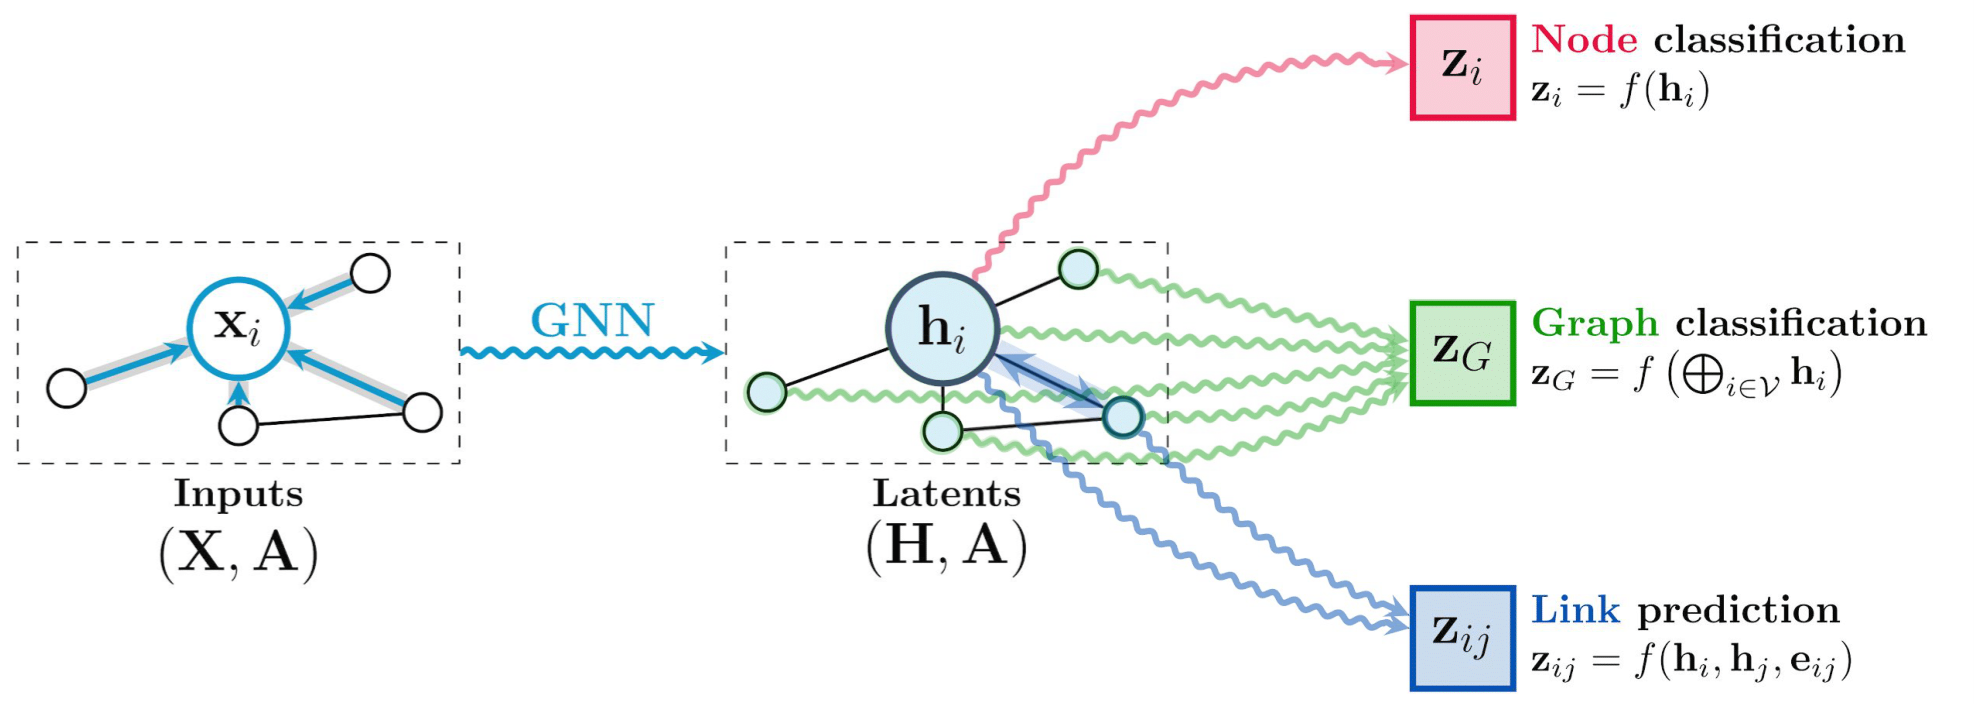

Remember that we are working on a graph classification task on the Mutagenicity dataset. This means that, after applying some convolution layers, we need to aggregate the node latent representations using a permutation invariant function. To this end, we will use the `global_add_pool` function. `global_add_pool` returns graph-level-outputs by adding node features across the node dimension, so that for a single graph $G_i$ its output is computed by
$$r_i = \sum_i ^N x_i.$$ `global_add_pool` takes as input the feature matrix `x` of the big batch graph and the `batch` tensor (see the section "Batching in Pytorch Geometric, above"). The batch tensor is used to correctly aggregate the node features within each graph in the batch.

## Exercise 4 (Network architecture)

Complete the missing parts in the implementation of the following GNN class. Define the convolution layers using the available GraphConv layer and keep the hidden layer feature dimension constant among the convolution layers. We first apply 5 convolutions (a ReLu activation is applied after each convolution). We then perform the `global_add_pool` and add two fully connected layers with a dropout. Finally, we conclude with a LogSoftmax, so that **our model outputs the log probabilities** of the molecule being or not mutagenetic. We prefer `LogSoftmax` to `SoftMax` since the first is more numerically stable.

In [ ]:
from torch.nn import Linear, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool

## TODO: Implement me :)
class GNN(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        hidden_dim,
        node_features_dim,
        edge_features_dim=None
    ):
        super(GNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Implement me!
        self.conv1 = ...
        self.conv2 = ...
        self.conv3 = ...
        self.conv4 = ...
        self.conv5 = ...

        # Implement me!
        self.fc1 = ...
        self.fc2 = Linear(hidden_dim, num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        # Implement me!
        ...
        ...
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

## Training
We are now ready to train our first GNN!

First, we prepare the dataloaders for train, validation and test data.

In [ ]:
from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

# If possible, we use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

idx_train_end = int(len(dataset) * .5)
idx_valid_end =  int(len(dataset) * .7)

BATCH_SIZE = 128
BATCH_SIZE_TEST = len(dataset) - idx_valid_end

# In the test loader we set the natch size to be equal to the size of the whole test set 
loader_train = DataLoader(dataset[:idx_train_end], batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(dataset[idx_train_end:idx_valid_end], batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(dataset[idx_valid_end:], batch_size=BATCH_SIZE_TEST, shuffle=False)

We initialize an instance of the GNN model we have defined above. We use negative log likelihood as loss function (`NLLLoss` in Pytorch), and Adam optimizer.

In [ ]:
from torch.nn import NLLLoss

# Model
model = GNN(
    num_classes = 2,
    hidden_dim=64,
    node_features_dim=dataset.num_node_features,
).to(device)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters())

# Loss function
loss_function = NLLLoss()

Finally, we can define the training loop and train our GNN model!

In [ ]:
from src import compute_accuracy

def train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS):
  # Prepare empy lists for logging
  train_losses = []
  train_accs = []
  val_accs = []

  for epoch in tqdm(range(N_EPOCHS)):
      epoch_loss = 0
      for batch in tqdm(loader_train, leave=False):
          batch.to(device)

          out = model(batch.x, batch.edge_index, batch.batch)
          loss = loss_function(out, batch.y.flatten())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc_train = compute_accuracy(model, loader_train)
          acc_valid = compute_accuracy(model, loader_valid)

          with torch.no_grad():
            train_accs.append(acc_train)
            val_accs.append(acc_valid)
            train_losses.append(loss)

      print(f"Epoch: {epoch}, Loss: {loss}")

  # Visualization at the end of training
  fig, ax = plt.subplots(dpi=100)
  ax.plot(train_accs, c="steelblue", label="Training")
  ax.plot(val_accs, c="orangered", label="Validation")
  ax.grid()
  ax.legend()
  ax.set_title("Accuracy evolution")
  plt.show()


In [ ]:
N_EPOCHS = 5
train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS)

After a few epochs the model accuracy is already reasonable. To load a model that has been pretrained for longer (50 epochs), uncomment and run the following cell.

In [ ]:
model.load_state_dict(torch.load("../checkpoints/pretrained_model.ckpt"))

## Evaluation

We can now see how our trained model performs on the test data and plot the corresponding confusion matrix.

## Exercise 5
Compute the test confusion matrix and plot it. Remember that we set the `test_loader` batch size t obe equal to the whole test set length. For computing the confusion matrix you may use the sklearn [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method, and you can plot it with [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Compute and plot the test confusion matrix!
...

You can check your results by running the following cell. You can find the implementation of the simple functions `compute_cm` and `plot_cm` in the script `visualization.py`.

In [ ]:
from src import compute_cm, plot_cm

print(f"Accuracy: {compute_accuracy(model, loader_test):.2%}""")

# Compute cm
cm = compute_cm(model, loader_test)
# Plot cm
plot_cm(cm)

The confusion matirx looks pretty good.

In this first part of the notebook, you have learned how to work with graphs in PyTorch Geometric. You have learned the fundamental principles underlying graph convolution and implemented and trained a simple GNN.

In the second part of this workshop, we are going to talk about explanability: why is the model predicting what it's predicting?

---

# III. Explainability

Let's try to **gain insights** from our trained model.

Ideally, we would like to be able to **infer why** the model predicts a certain output for a given input.
In particular, since we are working with _graphs_, we are interested in the **structural properties** that influence the outcome most.
Also, we want to provide interpretable explanations for predicitons made by **any GNN model**.

To this end, Ying, Rex et al. designed [GNN Explainer][1], a general,  model-agnostic approach for providing interpretable explanations for predictions of any GNN-based model on any graph-based machine learning task.

> Ying, Rex, et al. ["Gnnexplainer: Generating explanations for graph neural networks."][2] Advances in neural information processing systems 32 (2019): 9240.



[1]: https://github.com/RexYing/gnn-model-explainer
[2]: https://arxiv.org/abs/1903.03894


## Example

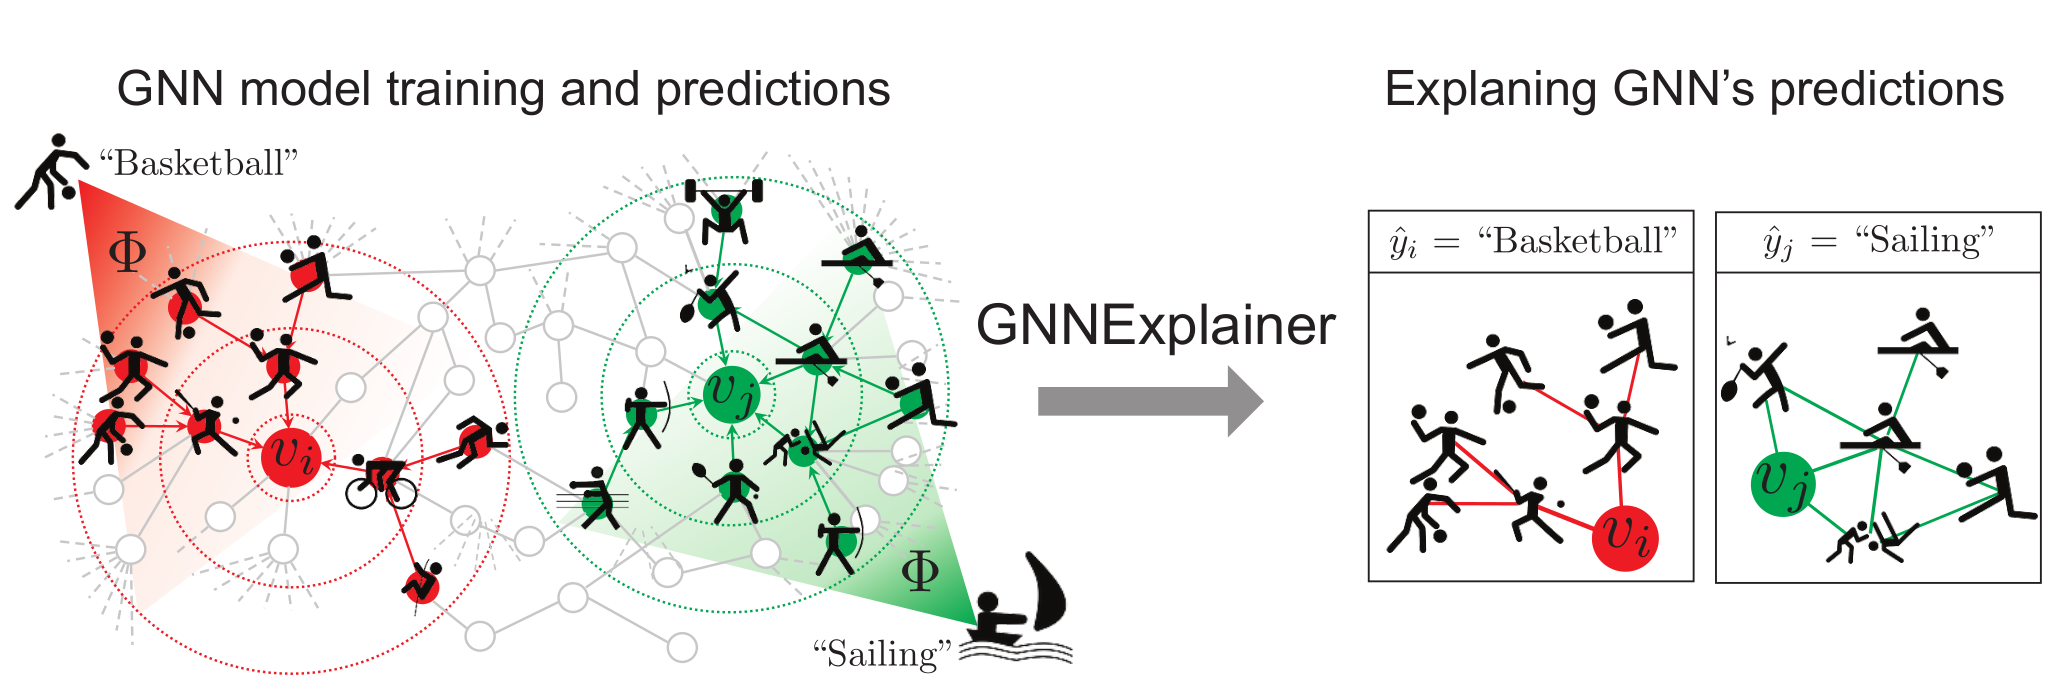

We show an hypotetical **node classification** task on a **social interaction graph**.
A GNN model is trained to predict future sport activities, and we would like to obtain an **explanation** motivating a certain prediction $\hat{y}_i =``Basketball"$  for person $v_i$, or $\hat{y}_i =``Sailing"$  for $v_j$.

The objective of GNNExplainer is to provide a _small subgraph_ together with a _small subset of features_ that is **most influetial** for the prediction output.

For instance, from the explanation of $\hat{y}_i$, we see that many friends among $v_i$ social circle enjoy ball games.
Similarly, by examining $\hat{y}_j$ explanation, we see that his friends and friends of his friends enjoy water and beach sports, motivating the prediction of "Sailing".

> _Figure and example from GNNExplainer paper._





This second half of the workshop is structured as follows:

1. Brief **theoretical motivation** of GNN Explainer
1. **Coding** the Explainer loss function for a graph classification task
1. Explain the results of the GNN model on molecules from **Mutagenicity**


## GNN Explainer

Ying, Rex et al. proposed GNN Explainer , an approach for explaining
predictions made by GNNs.
GNN Explainer **takes a trained GNN and its prediction**, and it **returns an
explanation** in the form of a small **subgraph** of the input graph together
with a small **subset of node features** that are most influential for the
prediction.



## Mathematical formulation

We need some measure of importance to choose which nodes and features should be included in the explanation. Let us denote the full computation graph (the input graph) with $G_c$, its adjacency matrix with $A_c$ and its feature set with $X_c$, where $X_c = \left \{x_1, ..., x_n \right \}, x_i \in \mathbb{R}^d$. With this notation, $n$ is the number of nodes and $d$ the number of features in the original computation graph.

A natural choice is to formulate the problem as an optimization of the [mutual information][mut_inf] ($MI$):
$$
    \underset{G_S, X_S^F}{\max} MI(Y, (G_S, X_S^F)) =
    H(Y) - H(y | G = G_S, X=X_S^F),
$$
where $H$ is the entropy function and $G_S$ is a subgraph of the input graph $G_c$. We indicate with $X_S$ the full set of features of the nodes in $G_S$, and with $X_S^F$ a subset of the features of the nodes of $G_S$: $F$ represents a binary feature selector such that $F = \left\{ 0, 1\right \}^d$ and $X_S^F = X_S \odot F.$

The mutual information, $MI$, is a measure of the **amount of information** obtained about one random variable (here the GNN's **prediction** $Y$), through observing another random variable (in this case the GNN prediction $y$ conditioned on a **subgraph** $G_S$ with **node features** $X_S^F$). In other words, the GNN prediction on a smaller explanation subgraph $G_S$ and restricted feature set should give us as much information as possible about the prediction on the full input graph: when this happens, we have selected the part of the graph and the feature subset that were really influent in determining the network output.

Since the entropy term $H(Y)$ is fixed over a trained GNN, this objective is equivalent to **minimizing the conditional entropy** $H(y | G = G_S, X=X_S^F)$.
This means that the explanation should **minimize the uncertainty** of the GNN when its computation is restricted to the explanation subgraph $G_S$.

[mut_inf]: https://en.wikipedia.org/wiki/Mutual_information

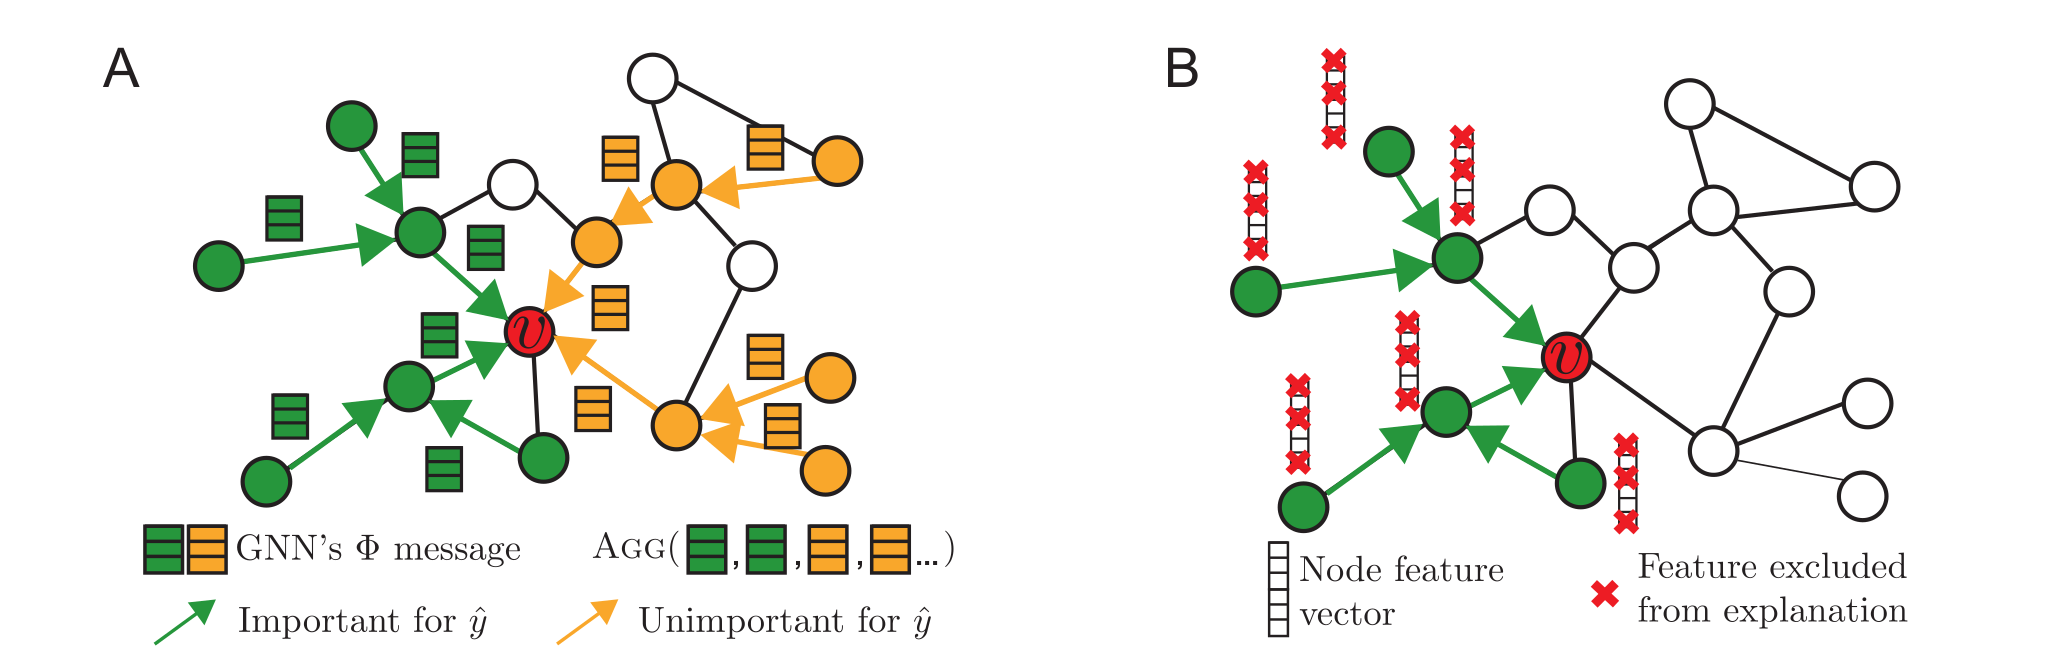

Querying for the explanation $\hat{y}$ of a node $v$, the mutual information should change only slightly when dropping unimportant nodes, while it would decrease consisently when excluding important ones.

By penalizing big explanations, we identify interesting subgraphs which incorporate most of the information relevant to the GNN output.

In the same way, we can exclude features by optimizing the feature mask against some penalization term.

## Optimization framework

Unfortunately, the $MI$ obective is intractable, as there exists exponentially
many subgraphs of the computational graph.

The authors of GNN Explainer propose a _relaxation_ and change the conditional
entropy with a **cross entropy**.
The objective becomes to learn an **edge mask**
$M \in \mathbb{R}^{n \times n}$ and a **feature selector** $F \in \mathbb{R}^d$, by minimizing the following:

$$
    \underset{M, F}{\min} -\sum_{c=1}^C \mathbf{1}_{y = c}
    \log P_{\Phi}(Y = y | G = A_c \odot \sigma(M), X = X_c \odot F).
$$
Note that if a component $f_i$ of $F$ is $1$, then the corresponding feature is important, while components pushed toward $0$ identify unuseful features.
On top of this objective, we include some penalization terms in the loss, to constrain the size and entropy of the mask and the feature selector.
In particular, we include

1. Constraint on the graph size: $\lambda_1 \|  \sigma(M) \|_1$
1. Constraint on the graph entropy:
$ \lambda_2 H \big( \sigma(M) \big)$ 
1. Constraint on the number of features: $\lambda_3 \| \sigma(F) \|_1,$

where $\sigma(\cdot)$ stands for the sigmoid function.

## Exercise 6

Implement the explainer loss function. As explained, the loss will be a weighted sum of four terms.

Instead of manually applying the edge mask on the `edge_index`, we can exploit the fuctionalities of Pytorch geometric. Indeed, all Pytorch geometric modules that work on graphs (e.g. GraphConv) can be made aware of the existence of an edge mask and will automatically apply the mask on the input `edge_index` in their forward pass. This detail is already implemented for you in the code below. Implement the loss function missing parts in the following cell.

In [ ]:
from torch_geometric.nn import MessagePassing
# TODO: implement me! :)

def graph_loss(
    x: torch.tensor,                     
    edge_index: torch.tensor,
    batch_index: torch.tensor,
    node_feat_mask: torch.nn.Parameter, 
    edge_mask: torch.nn.Parameter,      
    expl_label: int,
    model) -> torch.tensor:
    """
    Computes the explainer loss function for explanation
    of graph classificaiton tasks.

    Args:
        x : torch.Tensor
            Feature matrix of datapoint to explain.
        edge_index : torch.LongTensor
            A Tensor that defines the underlying graph connectivity/message
            passing flow. `edge_index` holds the indices of a general (sparse)
            assignment matrix of shape `[N, M]`. Its shape must be defined as
            `[2, num_messages]`, where messages from nodes in `edge_index[0]`
            are sent to nodes in `edge_index[1]`.
        batch_index : torch.LongTensor
            Column vector which maps each node to its respective graph in the batch.
        node_feat_mask : torch.nn.Parameter
            representing node feature mask of size [n_features]
        edge_mask : torch.nn.Parameter
            representing edge mask of size [n_edges]
        expl_label : int
            Label with respect to which we want the explanation.
        model : nn.Module
            a (pretrained) model
    Returns:
        loss (torch.tensor): explainer loss function, which
            is a weight sum of different terms.
    """
    # Apply sigmoid to masks
    edge_mask = edge_mask.sigmoid()
    node_feat_mask = node_feat_mask.sigmoid()

    # Loss terms weights
    coeffs = {"edge_size":0.01,
            "node_feat_size":0.07,
            "edge_entropy":1.0}

    # Mask node features
    h = ... # implement me!

    # Mask edges: instead of applying the mask on edge_index, make the model
    # aware of the mask
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.__explain__ = True
            module.__edge_mask__ = edge_mask

    # Compute model output (we assume the model already gives log probabilities)
    model_pred_log_proba = model(h, edge_index, batch_index)

    # Prediction loss.
    pred_loss = ... # implement me!

    # Edge mask size loss.
    edge_mask_size_loss = ... # implement me!

    # Edge mask entropy loss.
    ent_loss = ... # implement me!

    # Feature mask size loss.
    feat_mask_size_loss = ... # implement me!

    # Sum all loss terms
    loss = pred_loss + ... # implement me!

    return loss.sum()



In [ ]:
## Test your loss implementation does not throw any errors
import math
from copy import deepcopy
data_batch = next(iter(loader)).to(device)

x = data_batch.x
edge_index = data_batch.edge_index
batch_index = data_batch.batch

(nodes, feat), edges = x.size(), edge_index.size(1)

# Feat mask
node_feat_mask = torch.nn.Parameter(torch.randn(feat, device=device) * 0.1)

# Edge mask.
edge_mask = torch.nn.Parameter(torch.randn(edges, device=device) * 0.1)

expl_label = 1

loss = graph_loss(x,                     
    edge_index,
    batch_index,
    node_feat_mask, 
    edge_mask,      
    expl_label,
    deepcopy(model))

print(f"Computed loss : {round(loss.item(), 2)}")

## GNN Explainer implementation

We just defined the loss function to optimize with respect to two parameter
vectors (the edge mask and feature mask).
The most natural way to implement GNN Explainer and to optimize it is through
Pytorch mechanics.

We create a `GNNExplainer` class which inherits from `torch.nn.Module`.

At initialization, we give it the **trained model** for which we desire
explanations, as well as some optimization parameters.

```python
explainer = GNNExplainer(model, epochs=200).to(device)
```

Internally, the explainer keeps the **node feature mask** and the **edge mask**.



In [ ]:
from src import GNNExplainer

It implements the **graph loss** with following signature:
```python
GNNEXPLAINER.graph_loss(x, edge_index, batch_index, expl_label, **kwargs) -> torch.Tensor:
"""Computes the explainer loss function for explanation
of graph classificaiton tasks.

Parameters
----------
x : torch.Tensor
    Feature matrix of datapoint to explain.
edge_index : torch.LongTensor
        A Tensor that defines the underlying graph connectivity/message
        passing flow.
batch_index : torch.LongTensor
    Column vector which maps each node to its respective graph in the batch.
expl_label : int
    Label with respect to which we want the explanation.
**kwargs : optional
    Additional keyword arguments to be passed to the model. 

Returns
-------
torch.Tensor
    explainer loss function, which is a weighted sum of different terms.
"""
```


Finally, the method which most interests us is `explain_graph`. This method handles the intialization of the masks and optimizes them by reducing the loss function through gradient descent. Note that the complete implementation of the GNNExplainer class can be found in `src/explain.py`.

```python
GNNExplainer.explain_graph(
    x, edge_index, batch_index, expl_label, **kwargs
) -> (torch.nn.Parameter, torch.nn.Parameter):
"""Learns and returns a node feature mask and an edge mask that play a
crucial role to explain the prediction made by the GNN for graph
classification.

Parameters
----------
x : Tensor
    The node feature matrix.
edge_index : torch.LongTensor
    A Tensor that defines the underlying graph connectivity/message passing flow.
batch_index : torch.LongTensor
    Column vector which maps each node to its respective graph in the batch.
expl_label : int
    Label with respect to which we want the explanation.
**kwargs : optional
    Additional keyword arguments to be passed to the GNN model.

Returns
-------
torch.Tensor, torch.Tensor
    The node feature mask and edge mask
"""
```

This is the method we will use in the following.

## Exercise 7

Choose one graph from the dataset and compute its explanation (i.e. the feature and edge mask). Finally, the explanation is visualized using the `plot_mol` function.

In [ ]:
# Take a graph
data = dataset[0]
data.to(device)

# TODO: Initialize explainer
explainer = ...

# TODO: Train explainer
GNNExp_feat_mask, GNNExp_edge_mask = (..., ...)


# Plot the explanation
plot_mol(data, edge_mask=GNNExp_edge_mask)

## Interactive analysis

We will now interectively visualize and discuss the results for
the GNN Explainer.
You can use `src.make_interactive_explainer` to get an
interactive function which allows to choose which samples to
visualize (true positive, false positives, ...), and to
interactively change the threshold for the explanation
visualization.

You will see that `GNNExplainer` correclty identifies explanations for the model predictions: from domain knowledge we know for example that NO2 and NH2 groups are important for predicting the mutagenicity of a molecule, and GNNExplainer correctly identifies these groups.

Try it out!

In [ ]:
from src import make_interactive_explainer, explain_graph_visualized

In [ ]:
explainer_kwargs = dict(
    epochs=100,
    lr=0.04,
    edge_size=0.015,
    edge_ent=1.0,
    node_feat_size=0.07,
    node_feat_ent=0.1,
)

In [ ]:
make_interactive_explainer(
    model, dataset[idx_valid_end:],
    explainer_kwargs=explainer_kwargs,
    device=device
)

---

# Aknowledgements

This Notebook was developped by [**Visium SA**][visium] as part of the ["Shedding Light on obscure Graph Deep Learning"][workshop] workshop presented at the *Applied Machine Learning Days 2021*.

The **GNN Explainer** algorithm we present has been developed by [Ying et al.][GNNExplainer]
If you intend to use it for anything, please consider citing the original authors in your work:

```bibtex
@misc{ying2019gnnexplainer,
  title={GNNExplainer: Generating Explanations for Graph Neural Networks}, 
  author={Rex Ying and Dylan Bourgeois and Jiaxuan You and Marinka Zitnik and Jure Leskovec},
  year={2019},
  eprint={1903.03894},
  archivePrefix={arXiv},
  primaryClass={cs.LG}
}
```

The code in this repo is adapted and corrected for the AMLD workshop.
Our implementation of the explainer is based on PyTorch Geometric.

We also borrowed the notebook structure from [PyTorch Geometric tutorials][torch-geom-tuto]
and inspired our slides on the very good [seminar from Petar
Veličković][GNN-Seminar], from which we got some figures.

[visium]: https://www.visium.ch/
[workshop]: https://appliedmldays.org/events/amld-epfl-2021/workshops/shedding-light-on-obscure-graph-deep-learning

[GNNExplainer]: https://arxiv.org/abs/1903.03894
[torch-geom-tuto]: https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
[GNN-Seminar]: https://talks.cam.ac.uk/talk/index/155341
